<center><h1>Chang_Yi_HW7</h1></center>

Name: Yi Chang
<br>
Github Username: Evangeline-Chang
<br>
USC ID: 1959039727

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [31]:
import pandas as pd
import numpy as np
import statistics
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, silhouette_score, DistanceMetric, pairwise_distances
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn import metrics

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings("ignore")

### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
data = pd.read_csv('../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')
data.drop(columns=['RecordID'], inplace=True)
data.head(3)

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre


In [3]:
X = data.drop(columns=['Family', 'Genus', 'Species'])
y = data[['Family', 'Genus', 'Species']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_family = y_train[['Family']]
y_train_family['Family'] = y_train_family['Family'].astype('category')
y_train_family['label'] = y_train_family['Family'].cat.codes
y_test_family = y_test[['Family']]
y_test_family['Family'] = y_test_family['Family'].astype('category')
y_test_family['label'] = y_test_family['Family'].cat.codes

y_train_genus = y_train[['Genus']]
y_train_genus['Genus'] = y_train_genus['Genus'].astype('category')
y_train_genus['label'] = y_train_genus['Genus'].cat.codes
y_test_genus = y_test[['Genus']]
y_test_genus['Genus'] = y_test_genus['Genus'].astype('category')
y_test_genus['label'] = y_test_genus['Genus'].cat.codes

y_train_species = y_train[['Species']]
y_train_species['Species'] = y_train_species['Species'].astype('category')
y_train_species['label'] = y_train_species['Species'].cat.codes
y_test_species = y_test[['Species']]
y_test_species['Species'] = y_test_species['Species'].astype('category')
y_test_species['label'] = y_test_species['Species'].cat.codes

### (b) Train a classifier for each label

#### (i) Research

- Exact Match: the ratio of the number of correctly predicted instances for all labels to the total number of instances
    - A more straightforward measure of **overall** classification accuracy; suitable when we want all labels for an instance to be correctly predicted.
- Hamming Score/Loss: the average similarity between the predicted and true label sets
    - Considers each label independently; suitable when instances can have multiple correct labels, and we want to evaluate the model's performance label-wise.

#### (ii) Train a SVM for each of the labels

In [87]:
C_range = np.logspace(-3, 6, 10)
gamma_range = np.arange(0.1, 2.1, 0.1) 

def svm(label, X_train, X_test, y_train, y_test):
    param_grid = {'C': C_range, 'gamma': gamma_range}
    grid_search = GridSearchCV(SVC(), param_grid, cv=10)
    grid_search.fit(X_train, y_train['label'])
    best_params = grid_search.best_params_
    print('Best Parameters for ', label, ': ', best_params, sep='')
    svm = SVC(C=best_params['C'], gamma=best_params['gamma'])
    svm.fit(X_train, y_train['label'])
    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)
    train_acc = accuracy_score(y_train['label'], y_train_pred)
    test_acc = accuracy_score(y_test['label'], y_test_pred)
    print(label, '- Accuracy (Training):', f'{train_acc:.5f}')
    print(label, '- Accuracy (Test):', f'{test_acc:.5f}', '\n')

svm('Family', X_train, X_test, y_train_family, y_test_family)
svm('Genus', X_train, X_test, y_train_genus, y_test_genus)
svm('Species', X_train, X_test, y_train_species, y_test_species)

Best Parameters for Family: {'C': 10.0, 'gamma': 2.0}
Family - Accuracy (Training): 0.99980
Family - Accuracy (Test): 0.99398 

Best Parameters for Genus: {'C': 100.0, 'gamma': 1.5000000000000002}
Genus - Accuracy (Training): 1.00000
Genus - Accuracy (Test): 0.99074 

Best Parameters for Species: {'C': 10.0, 'gamma': 1.8000000000000003}
Species - Accuracy (Training): 0.99980
Species - Accuracy (Test): 0.99027 



#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C_range = np.logspace(-3, 6, 10)

def l1_svm(label, X_train, X_test, y_train, y_test):
    param_grid = {'C': C_range}
    grid_search = GridSearchCV(LinearSVC(penalty='l1', dual=False), param_grid, cv=10)
    grid_search.fit(X_train, y_train['label'])
    best_params = grid_search.best_params_
    print('Best Parameters for', label, '(L1 SVM):', best_params)
    svm = LinearSVC(C=best_params['C'], penalty='l1', dual=False)
    svm.fit(X_train, y_train['label'])
    y_pred = svm.predict(X_test)
    train_acc = accuracy_score(y_train['label'], svm.predict(X_train))
    test_acc = accuracy_score(y_test['label'], y_pred)
    print(label, '(L1 SVM) Accuracy - Training:', f'{train_acc:.5f}')
    print(label, '(L1 SVM) Accuracy - Test:', f'{test_acc:.5f}')
    precision_test = precision_score(y_test['label'], y_pred, average='macro')
    recall_test = recall_score(y_test['label'], y_pred, average='macro')
    print(label, '(L1 SVM) Precision - Test:', f'{precision_test:.5f}')
    print(label, '(L1 SVM) Recall - Test:', f'{recall_test:.5f}', '\n')

l1_svm('Family', X_train_scaled, X_test_scaled,y_train_family, y_test_family)
l1_svm('Genus', X_train_scaled, X_test_scaled,y_train_genus, y_test_genus)
l1_svm('Species', X_train_scaled, X_test_scaled,y_train_species, y_test_species)

Best Parameters for Family (L1 SVM): {'C': 1.0}
Family (L1 SVM) Accuracy - Training: 0.94261
Family (L1 SVM) Accuracy - Test: 0.92867
Family (L1 SVM) Precision - Test: 0.67597
Family (L1 SVM) Recall - Test: 0.69041 

Best Parameters for Genus (L1 SVM): {'C': 10.0}
Genus (L1 SVM) Accuracy - Training: 0.95651
Genus (L1 SVM) Accuracy - Test: 0.94164
Genus (L1 SVM) Precision - Test: 0.92358
Genus (L1 SVM) Recall - Test: 0.76904 

Best Parameters for Species (L1 SVM): {'C': 10.0}
Species (L1 SVM) Accuracy - Training: 0.96485
Species (L1 SVM) Accuracy - Test: 0.95924
Species (L1 SVM) Precision - Test: 0.92541
Species (L1 SVM) Recall - Test: 0.89476 



#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'svm__C': np.logspace(-3, 6, 10)}

def l1_svm_smote(label, X_train, X_test, y_train, y_test):
    pipeline = imbpipeline([('smote', SMOTE(random_state=42)),
                            ('svm', LinearSVC(penalty='l1', dual=False))])
    grid_search = GridSearchCV(pipeline, param_grid, cv=10)
    grid_search.fit(X_train, y_train['label'])
    best_params = grid_search.best_params_
    print('Best Parameters for', label, '(L1 SVM with SMOTE):', best_params)
    y_pred = grid_search.predict(X_test)
    train_acc = accuracy_score(y_train['label'], grid_search.predict(X_train))
    test_acc = accuracy_score(y_test['label'], y_pred)
    print(label, '(L1 SVM with SMOTE) Accuracy - Training:', f'{train_acc:.5f}')
    print(label, '(L1 SVM with SMOTE) Accuracy - Test:', f'{test_acc:.5f}')
    precision_test = precision_score(y_test['label'], y_pred, average='macro')
    recall_test = recall_score(y_test['label'], y_pred, average='macro')
    print(label, '(L1 SVM with SMOTE) Precision - Test:', f'{precision_test:.5f}')
    print(label, '(L1 SVM with SMOTE) Recall - Test:', f'{recall_test:.5f}', '\n')

l1_svm_smote('Family', X_train_scaled, X_test_scaled, y_train_family, y_test_family)
l1_svm_smote('Genus', X_train_scaled, X_test_scaled, y_train_genus, y_test_genus)
l1_svm_smote('Species', X_train_scaled, X_test_scaled, y_train_species, y_test_species)

Best Parameters for Family (L1 SVM with SMOTE): {'svm__C': 10.0}
Family (L1 SVM with SMOTE) Accuracy - Training: 0.92415
Family (L1 SVM with SMOTE) Accuracy - Test: 0.90922
Family (L1 SVM with SMOTE) Precision - Test: 0.74209
Family (L1 SVM with SMOTE) Recall - Test: 0.91307 

Best Parameters for Genus (L1 SVM with SMOTE): {'svm__C': 10000.0}
Genus (L1 SVM with SMOTE) Accuracy - Training: 0.92057
Genus (L1 SVM with SMOTE) Accuracy - Test: 0.90088
Genus (L1 SVM with SMOTE) Precision - Test: 0.73974
Genus (L1 SVM with SMOTE) Recall - Test: 0.91506 

Best Parameters for Species (L1 SVM with SMOTE): {'svm__C': 1.0}
Species (L1 SVM with SMOTE) Accuracy - Training: 0.96406
Species (L1 SVM with SMOTE) Accuracy - Test: 0.95739
Species (L1 SVM with SMOTE) Precision - Test: 0.88404
Species (L1 SVM with SMOTE) Recall - Test: 0.92731 



After applying SMOTE, although there was no noticeable enhancement and even a decline in the accuracy score for the test data, there is a notable improvement in recall scores. This enhancement is particularly evident in the `family` label.<br>

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering
### (b) Determine which family is the majority
### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

- Hamming Distance: the number of positions at which the corresponding elements in two equal-length sequences are different
- Hamming Score (Accuracy): accuracy of the predicted labels compared to the true labels
- Hamming Loss: the fraction of labels that are incorrectly predicted

In [3]:
X = data.drop(columns=['Family', 'Genus', 'Species'])
y = data[['Family', 'Genus', 'Species']]

In [35]:
final_ham_loss = []
final_ham_score = []
final_ham_loss_family = []
final_ham_loss_genus = []
final_ham_loss_species = []

fam_maj_trip = {p: [] for p in range(1, 51)}
genus_maj_trip = {p: [] for p in range(1, 51)}
species_maj_trip = {p: [] for p in range(1, 51)}
major_trip = {}
final_data = []

for cls in tqdm(range(1, 51)):
    silh_avg = dict()

    for k in range(2, 51):   # Silhouette score requires at least two clusters
        rand_value = random.randint(0, 900)
        k_means = KMeans(n_clusters=k, random_state=rand_value).fit(X)
        labels = k_means.labels_
        silh_avg.update({k: metrics.silhouette_score(X, labels)})

    optimal_k = max(silh_avg, key=silh_avg.get)
    rand_value1 = random.randint(0, 900)

    k_means_f = KMeans(n_clusters=optimal_k, random_state=rand_value1).fit(X)
    cluster_labels = k_means_f.labels_

    clusters = pd.concat([X, y, pd.DataFrame({'labels': cluster_labels.tolist()})], axis=1)
    clusters['labels'].value_counts()

    maj_trip = {k: [] for k in range(optimal_k)}
    for k in range(optimal_k):
        c_value = clusters[clusters['labels'] == k]
        fam_majority = c_value['Family'].value_counts().idxmax()
        genus_majority = c_value['Genus'].value_counts().idxmax()
        species_majority = c_value['Species'].value_counts().idxmax()
        maj_trip[k].extend([fam_majority, genus_majority, species_majority])
        fam_maj_trip[cls].append(tuple(maj_trip[k]))

    clusters['family_pred'] = 'none'
    clusters['genus_pred'] = 'none'
    clusters['species_pred'] = 'none'

    for k in range(optimal_k):
        clusters['family_pred'] = np.where(clusters['labels'] == k, maj_trip[k][0], clusters['family_pred'])
        clusters['genus_pred'] = np.where(clusters['labels'] == k, maj_trip[k][1], clusters['genus_pred'])
        clusters['species_pred'] = np.where(clusters['labels'] == k, maj_trip[k][2], clusters['species_pred'])

    hamming_loss_family = hamming_loss(clusters['Family'], clusters['family_pred'])
    hamming_loss_genus = hamming_loss(clusters['Genus'], clusters['genus_pred'])
    hamming_loss_species = hamming_loss(clusters['Species'], clusters['species_pred'])

    ham_loss_s = (hamming_loss_family + hamming_loss_genus + hamming_loss_species) / 3

    final_ham_loss.append(np.round(ham_loss_s, 6))
    final_ham_score.append((1 - ham_loss_s))

    final_ham_loss_family.append(hamming_loss_family)
    final_ham_loss_genus.append(hamming_loss_genus)
    final_ham_loss_species.append(hamming_loss_species)

    major_trip[cls] = maj_trip

    final_data.append({
        "Iteration": cls,
        "Optimal K": optimal_k,
        "Hamming Score": 1 - ham_loss_s,
        "Hamming Distance": ham_loss_s,
        "Hamming Loss (Family)": hamming_loss_family,
        "Hamming Loss (Genus)": hamming_loss_genus,
        "Hamming Loss (Species)": hamming_loss_species,
        "Majority triplets (Family, Genus, Species) for every cluster": fam_maj_trip[cls]
    })

std_ham_score = statistics.stdev(final_ham_score)
std_ham_dis = statistics.stdev(final_ham_loss)
avg_ham_score = statistics.mean(final_ham_score)
avg_ham_dis = statistics.mean(final_ham_loss)

print(f"\nStandard Deviation Hamming Scores: {std_ham_score:.8f}")
print(f"Standard Deviation Hamming Distances: {std_ham_dis:.8f}")
print(f"Average of Hamming Scores: {avg_ham_score:.5f}")
print(f"Average of Hamming Distances: {avg_ham_dis:.5f}")

final_df = pd.DataFrame(final_data)
final_df

100%|██████████| 50/50 [49:41<00:00, 59.62s/it]   


Standard Deviation Hamming Scores: 0.00608927
Standard Deviation Hamming Distances: 0.00608925
Average of Hamming Scores: 0.77533
Average of Hamming Distances: 0.22467


,Iteration,Optimal K,Hamming Score,Hamming Distance,Hamming Loss (Family),Hamming Loss (Genus),Hamming Loss (Species),"Majority triplets (Family, Genus, Species) for every cluster"
0,1,4,0.777577,0.222423,0.193607,0.229187,0.244475,"[(Leptodactylidae, Adenomera, AdenomeraHylaeda..."
1,2,4,0.777577,0.222423,0.193607,0.229187,0.244475,"[(Hylidae, Hypsiboas, HypsiboasCordobae), (Lep..."
2,3,4,0.754876,0.245124,0.164142,0.254204,0.317026,"[(Hylidae, Hypsiboas, HypsiboasCordobae), (Lep..."
3,4,4,0.777577,0.222423,0.193607,0.229187,0.244475,"[(Hylidae, Hypsiboas, HypsiboasCinerascens), (..."
4,5,4,0.777577,0.222423,0.193607,0.229187,0.244475,"[(Hylidae, Hypsiboas, HypsiboasCordobae), (Hyl..."
5,6,4,0.777716,0.222284,0.193468,0.229048,0.244336,"[(Leptodactylidae, Adenomera, AdenomeraHylaeda..."
6,7,4,0.777577,0.222423,0.193607,0.229187,0.244475,"[(Hylidae, Hypsiboas, HypsiboasCinerascens), (..."
7,8,4,0.777577,0.222423,0.193607,0.229187,0.244475,"[(Hylidae, Hypsiboas, HypsiboasCordobae), (Lep..."
8,9,4,0.777855,0.222145,0.193329,0.228909,0.244197,"[(Leptodactylidae, Adenomera, AdenomeraHylaeda..."
9,10,4,0.777577,0.222423,0.193607,0.229187,0.244475,"[(Leptodactylidae, Adenomera, AdenomeraHylaeda..."


## 3. ISLR 12.6.2

#### (a)

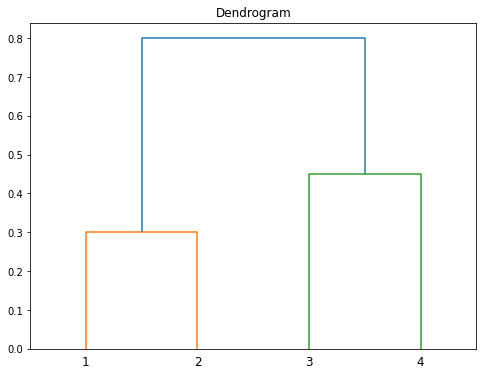

In [26]:
dis_mat = np.array([[0.0, 0.3, 0.4, 0.7], [0.3, 0.0, 0.5, 0.8], [0.4, 0.5, 0.0, 0.45], [0.7, 0.8, 0.45, 0.0]])
dists = squareform(dis_mat)
linkage_matrix = linkage(dists, "complete")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
dendrogram(linkage_matrix, labels=['1', '2', '3', '4'])
plt.title("Dendrogram")
plt.show()

#### (b)

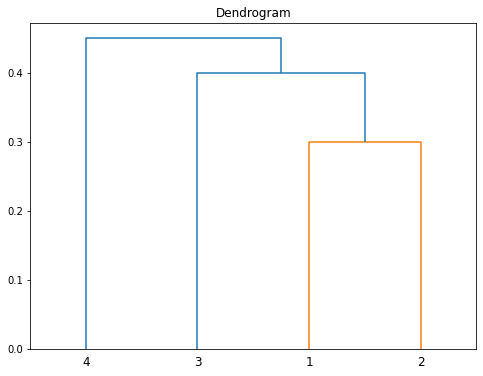

In [27]:
linkage_matrix = linkage(dists, "single")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
dendrogram(linkage_matrix, labels=['1', '2', '3', '4'])
plt.title("Dendrogram")
plt.show()

#### (c)
Observations 1 and 2 in a cluster; 3 and 4 in another.

#### (d)
Observations 1, 2, 3 in a cluster, and 4 in another.

#### (e)

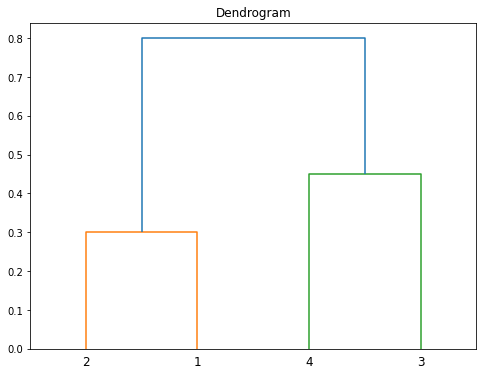

In [28]:
linkage_matrix = linkage(dists, "complete")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
dendrogram(linkage_matrix, labels=['2', '1', '4', '3'])
plt.title("Dendrogram")
plt.show()